# Validation of BoostDM-CH in Gao et al exclusive

## 541 mutations (477 unique)

### 1. Get Gao exclusive mutations in 12 BoostDM genes (only SNVs)
### 2. Eliminate mutations from TCGA & HMF
### 3. Create negative set
### 4. Evaluation BoostDM vs Expert curated rules - 6 genes 
### 5. Evaluation BoostDM vs Expert curated rules - gene by gene

In [2]:
import pandas as pd
import numpy as np
import os
from io import StringIO
import copy
import gzip
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact


pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 75)

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 200

# 1. Get Gao exclusive mutations in 12 BoostDM genes (only SNVs)

In [4]:
### Open Gao et al NatCom 2021 (MSKCC)

MSKCC_Gao = pd.read_csv("/workspace/projects/clonalhemato_ukb/ukb_200k/analysis_200k_202106/ukb200_8_CH_positive_sets/CH_mutations_datasets/Gao_NatCom_2021.csv")
print(len(MSKCC_Gao))
MSKCC_Gao.columns

14789


Index(['dmp_patient_id', 'Chrom', 'Start', 'Ref', 'Alt', 'VAF_N',
       'VariantClass', 'Gene', 'Exon', 'cDNAchange', 'AAchange',
       'N_TotalDepth', 'N_RefCount', 'N_AltCount'],
      dtype='object')

In [5]:
### Select 12 Ch genes
genes12 = ['ASXL1', 'CHEK2', 'DNMT3A', 'GNAS', 'IDH2', 'MDM4', 'PPM1D', 'SF3B1', 'SRSF2', 'TET2', 'TP53', 'U2AF1']
MSKCC_Gao_sel = MSKCC_Gao[MSKCC_Gao['Gene'].isin(genes12)]
print(len(MSKCC_Gao_sel))
MSKCC_Gao_sel['Gene'].value_counts(normalize=True)

8013


DNMT3A    0.523899
TET2      0.152752
PPM1D     0.121303
ASXL1     0.057032
TP53      0.047173
CHEK2     0.038562
SF3B1     0.022463
SRSF2     0.013728
GNAS      0.008611
U2AF1     0.005865
MDM4      0.004742
IDH2      0.003869
Name: Gene, dtype: float64

In [7]:
### Select only SNVs
MSKCC_Gao_sel = MSKCC_Gao_sel[MSKCC_Gao_sel['Ref'].isin(['A','C','T','G']) &
                              MSKCC_Gao_sel['Alt'].isin(['A','C','T','G'])].reset_index(drop=True)
print(MSKCC_Gao_sel['VariantClass'].value_counts())

Missense_Mutation         3798
Nonsense_Mutation         1571
Splice_Site                501
Splice_Region               11
5'UTR                        8
Translation_Start_Site       3
3'UTR                        2
Nonstop_Mutation             1
Name: VariantClass, dtype: int64


In [8]:
### Arrange data

# Change chromosome nomenclature
MSKCC_Gao_sel['Chrom'] = MSKCC_Gao_sel['Chrom'].astype(int)

In [9]:
### Get position hg38

from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')

def hg38_conv (x):
    try:
        hg38 = lo.convert_coordinate('chr' + str(x['Chrom']), x['Start'])[0][1]
        return hg38
    except:
        print('WARNING: not transformed')
        print(x['Chromosome'], x['Start_Position'])

# Apply to initial dataset
MSKCC_Gao['pos_hg38'] = MSKCC_Gao_sel.apply(lambda x: hg38_conv(x), axis=1)        

# Apply to 12 genes selection
MSKCC_Gao_sel['pos_hg38'] = MSKCC_Gao_sel.apply(lambda x: hg38_conv(x), axis=1)

In [10]:
### Open Bolton et al NatGen 2020 (MSKCC)

MSKCC_Bolton = pd.read_csv("/workspace/projects/clonalhemato_ukb/ukb_200k/analysis_200k_202106/ukb200_8_CH_positive_sets/CH_mutations_datasets/data_mutations_mskcc.txt",
                           sep="\t", skiprows=2)
print(len(MSKCC_Bolton))
MSKCC_Bolton.columns

11076


Index(['Hugo_Symbol', 'Entrez_Gene_Id', 'Center', 'NCBI_Build', 'Chromosome',
       'Start_Position', 'End_Position', 'Strand', 'Consequence',
       'Variant_Classification', 'Variant_Type', 'Reference_Allele',
       'Tumor_Seq_Allele1', 'Tumor_Seq_Allele2', 'dbSNP_RS',
       'dbSNP_Val_Status', 'Tumor_Sample_Barcode',
       'Matched_Norm_Sample_Barcode', 'Match_Norm_Seq_Allele1',
       'Match_Norm_Seq_Allele2', 'Tumor_Validation_Allele1',
       'Tumor_Validation_Allele2', 'Match_Norm_Validation_Allele1',
       'Match_Norm_Validation_Allele2', 'Verification_Status',
       'Validation_Status', 'Mutation_Status', 'Sequencing_Phase',
       'Sequence_Source', 'Validation_Method', 'Score', 'BAM_File',
       'Sequencer', 't_ref_count', 't_alt_count', 'n_ref_count', 'n_alt_count',
       'HGVSc', 'HGVSp', 'HGVSp_Short', 'Transcript_ID', 'RefSeq',
       'Protein_position', 'Codons', 'Hotspot', 'cbp_driver',
       'cbp_driver_annotation'],
      dtype='object')

In [11]:
### Select 12 Ch genes
MSKCC_Bolton_sel = MSKCC_Bolton[MSKCC_Bolton['Hugo_Symbol'].isin(genes12)]
print(len(MSKCC_Bolton_sel))
MSKCC_Bolton_sel['Hugo_Symbol'].value_counts()

5568


DNMT3A    2890
TET2       835
PPM1D      702
ASXL1      312
TP53       276
CHEK2      221
SF3B1      121
SRSF2       66
GNAS        47
U2AF1       40
MDM4        31
IDH2        27
Name: Hugo_Symbol, dtype: int64

In [12]:
### Select only SNVs

MSKCC_Bolton_sel = MSKCC_Bolton_sel[MSKCC_Bolton_sel['Reference_Allele'].isin(['A','C','T','G']) &
                              MSKCC_Bolton_sel['Tumor_Seq_Allele1'].isin(['A','C','T','G'])].reset_index(drop=True)
print(len(MSKCC_Bolton_sel))

4797


In [13]:
### Arrage data

# Change chromosome nomenclature
#MSKCC_Bolton_sel['Chromosome'] = MSKCC_Bolton_sel['Chromosome'].apply(lambda x: 'chr' + str(x))
MSKCC_Bolton_sel['Chromosome'] = MSKCC_Bolton_sel['Chromosome'].astype(int)

# Remove "." in "protein_position"
MSKCC_Bolton_sel['Protein_position'] = MSKCC_Bolton_sel['Protein_position'].apply(lambda x: str(x).split('.')[0])

In [14]:
### Get position hg38

from pyliftover import LiftOver
lo = LiftOver('hg19', 'hg38')

def hg38_conv (x):
    try:
        hg38 = lo.convert_coordinate('chr' + str(x['Chromosome']), x['Start_Position'])[0][1]
        return hg38
    except:
        print('WARNING: not transformed')
        print(x['Chromosome'], x['Start_Position'])
        
MSKCC_Bolton_sel['pos_hg38'] = MSKCC_Bolton_sel.apply(lambda x: hg38_conv(x), axis=1)

In [15]:
### Get Bolton unique mutations

MSKCC_Bolton_uniq = MSKCC_Bolton_sel.groupby(['Chromosome', 'pos_hg38', 'Reference_Allele','Tumor_Seq_Allele2','Hugo_Symbol', 'Variant_Classification'],
                                             as_index=False).size()
print(len(MSKCC_Bolton_uniq))

2167


In [16]:
### Get Gao exclusive mutations (not present in Bolton)

Gao_Exclusive = pd.merge(MSKCC_Gao_sel, MSKCC_Bolton_uniq, how='left',
                         left_on=['Gene','Chrom', 'pos_hg38','Ref', 'Alt'],
                         right_on=['Hugo_Symbol','Chromosome','pos_hg38', 'Reference_Allele','Tumor_Seq_Allele2'])
print(len(Gao_Exclusive))
Gao_Exclusive = Gao_Exclusive[Gao_Exclusive['Hugo_Symbol'].isna()].reset_index(drop=True)
print(Gao_Exclusive['VariantClass'].value_counts())

5895
Missense_Mutation         365
Nonsense_Mutation         161
Splice_Site                27
Splice_Region              11
5'UTR                       8
Translation_Start_Site      2
3'UTR                       2
Nonstop_Mutation            1
Name: VariantClass, dtype: int64


In [17]:
### Eliminate extra columns
Gao_Exclusive = Gao_Exclusive.iloc[:,:15]

In [18]:
### unique mutations
Gao_Exclusive[['Chrom','Gene','pos_hg38','Ref','Alt']].drop_duplicates().reset_index(drop=True)

,Chrom,Gene,pos_hg38,Ref,Alt
0,2,DNMT3A,25235734,T,A
1,17,TP53,7675233,A,T
2,2,DNMT3A,25247070,G,A
3,2,DNMT3A,25239131,T,A
4,2,SF3B1,197435023,G,A
...,...,...,...,...,...
498,4,TET2,105235866,C,A
499,2,SF3B1,197402647,G,C
500,2,DNMT3A,25246202,C,A
501,22,CHEK2,28699938,C,T


In [19]:
Gao_Exclusive.Gene.value_counts()

DNMT3A    231
TET2      156
CHEK2      57
TP53       49
ASXL1      38
SF3B1      19
PPM1D      11
GNAS        5
SRSF2       5
IDH2        3
MDM4        2
U2AF1       1
Name: Gene, dtype: int64

# 2. Eliminate mutations from TCGA & HMF

In [21]:
Gao_Exclusive_positive = copy.deepcopy(Gao_Exclusive)
print(len(Gao_Exclusive_positive))

577


### 2A. MSKCC IMPACT (as control because it is = to Bolton)

In [23]:
### MSKCC IMPACT (as control should be = to Bolton)

# Open observed mutaitons from MSKCC
MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",
                          sep='\t')
print(len(MSKCC_IMPACT))
MSKCC_IMPACT.columns

246585


/tmp/jobs/jramis/9874679/ipykernel_5683/2475993912.py:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  MSKCC_IMPACT = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_CH_IMPACT_PANEL.regression_data.tsv",


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [24]:
### Arrange data
# Select 12 genes
print(len(MSKCC_IMPACT))
MSKCC_IMPACT = MSKCC_IMPACT[MSKCC_IMPACT['gene'].isin(genes12)].reset_index(drop=True)
print(len(MSKCC_IMPACT))

# Transform chromosome to int
MSKCC_IMPACT['chr'] = MSKCC_IMPACT['chr'].astype(int)

246585
206040


In [25]:
# Take observed
MSKCC_IMPACT_observed = MSKCC_IMPACT[MSKCC_IMPACT['response']==1].reset_index(drop=True)
print(len(MSKCC_IMPACT_observed))


4040


In [26]:
# Type of mutations
MSKCC_IMPACT_observed[['csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing', 'csqn_type_synonymous']].sum()

csqn_type_missense      2598
csqn_type_nonsense      1091
csqn_type_splicing       350
csqn_type_synonymous       0
dtype: int64

In [27]:
print(Gao_Exclusive_positive.columns)
print(MSKCC_IMPACT_observed.columns)

Index(['dmp_patient_id', 'Chrom', 'Start', 'Ref', 'Alt', 'VAF_N',
       'VariantClass', 'Gene', 'Exon', 'cDNAchange', 'AAchange',
       'N_TotalDepth', 'N_RefCount', 'N_AltCount', 'pos_hg38'],
      dtype='object')
Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')


In [28]:
# Merge and exclude the ones present
Gao_Exclusive_positive = pd.merge(Gao_Exclusive_positive, MSKCC_IMPACT_observed, how='left',
                                  left_on=['Gene','Chrom', 'pos_hg38','Ref', 'Alt'],
                                  right_on=['gene','chr','pos', 'ref','alt'])
print(len(Gao_Exclusive_positive))
Gao_Exclusive_positive = Gao_Exclusive_positive[Gao_Exclusive_positive['alt'].isna()].reset_index(drop=True)
print(len(Gao_Exclusive_positive))

577
577


In [30]:
### Eliminate extra columns
Gao_Exclusive_positive = Gao_Exclusive_positive.iloc[:,:15]
Gao_Exclusive_positive.columns

Index(['dmp_patient_id', 'Chrom', 'Start', 'Ref', 'Alt', 'VAF_N',
       'VariantClass', 'Gene', 'Exon', 'cDNAchange', 'AAchange',
       'N_TotalDepth', 'N_RefCount', 'N_AltCount', 'pos_hg38'],
      dtype='object')

### 2B. TCGA

In [31]:
# Open TCGA observed mutations
TCGA = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WXS_TCGA_FULL.regression_data.tsv",
                          sep='\t')
print(len(TCGA))
TCGA.columns

23205


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [32]:
### Arrange data
# Select 12 genes
print(len(TCGA))
TCGA = TCGA[TCGA['gene'].isin(genes12)].reset_index(drop=True)
print(len(TCGA))

# Transform chromosome to int
TCGA['chr'] = TCGA['chr'].astype(int)

23205
16116


In [34]:
# Take observed
TCGA_observed = TCGA[TCGA['response']==1].reset_index(drop=True)
len(TCGA_observed)

316

In [35]:
# Take unique
TCGA_observed_unique = TCGA_observed[['gene','chr','pos', 'ref','alt']].drop_duplicates().reset_index(drop=True)
TCGA_observed_unique

,gene,chr,pos,ref,alt
0,ASXL1,20,32433735,G,T
1,ASXL1,20,32434825,G,T
2,ASXL1,20,32434981,C,T
3,ASXL1,20,32433492,C,T
4,ASXL1,20,32435356,C,T
...,...,...,...,...,...
262,TET2,4,105237274,T,A
263,TET2,4,105275548,C,T
264,TET2,4,105236598,C,T
265,TET2,4,105261783,C,T


In [36]:
# Merge and exclude the ones present
Gao_Exclusive_positive = pd.merge(Gao_Exclusive_positive, TCGA_observed_unique, how='left',
                                  left_on=['Gene','Chrom', 'pos_hg38','Ref', 'Alt'],
                                  right_on=['gene','chr','pos', 'ref','alt'])
print(len(Gao_Exclusive_positive))
Gao_Exclusive_positive = Gao_Exclusive_positive[Gao_Exclusive_positive['alt'].isna()].reset_index(drop=True)
print(len(Gao_Exclusive_positive))

577
557


In [40]:
### Eliminate extra columns
Gao_Exclusive_positive = Gao_Exclusive_positive.iloc[:,:15]
Gao_Exclusive_positive.columns

Index(['dmp_patient_id', 'Chrom', 'Start', 'Ref', 'Alt', 'VAF_N',
       'VariantClass', 'Gene', 'Exon', 'cDNAchange', 'AAchange',
       'N_TotalDepth', 'N_RefCount', 'N_AltCount', 'pos_hg38'],
      dtype='object')

### 2C. HMF

In [41]:
# Open TCGA observed mutations
HMF = pd.read_csv("/workspace/projects/boostdm_ch/output/run_20230802_includeLowQuality/create_datasets/OTHER_WGS_HMF_FULL.regression_data.tsv",
                          sep='\t')
print(len(HMF))
HMF.columns

10047


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [42]:
### Arrange data
# Select 12 genes
print(len(HMF))
HMF = HMF[HMF['gene'].isin(genes12)].reset_index(drop=True)
print(len(HMF))

# Transform chromosome to int
HMF['chr'] = HMF['chr'].astype(int)

10047
8568


In [43]:
# Take observed
HMF_observed = HMF[HMF['response']==1].reset_index(drop=True)
len(HMF_observed)

168

In [44]:
# Take unique
HMF_observed_unique = HMF_observed[['gene','chr','pos', 'ref','alt']].drop_duplicates().reset_index(drop=True)
HMF_observed_unique

,gene,chr,pos,ref,alt
0,ASXL1,20,32428366,G,T
1,ASXL1,20,32433447,C,T
2,ASXL1,20,32435036,T,A
3,ASXL1,20,32435284,C,T
4,ASXL1,20,32436955,C,T
...,...,...,...,...,...
125,TP53,17,7674221,G,A
126,TP53,17,7674872,T,C
127,U2AF1,21,43104346,G,A
128,U2AF1,21,43094670,C,T


In [45]:
# Merge and exclude the ones present
Gao_Exclusive_positive = pd.merge(Gao_Exclusive_positive, HMF_observed_unique, how='left',
                                  left_on=['Gene','Chrom', 'pos_hg38','Ref', 'Alt'],
                                  right_on=['gene','chr','pos', 'ref','alt'])
print(len(Gao_Exclusive_positive))
Gao_Exclusive_positive = Gao_Exclusive_positive[Gao_Exclusive_positive['alt'].isna()].reset_index(drop=True)
print(len(Gao_Exclusive_positive))

557
541


In [47]:
Gao_Exclusive_positive = Gao_Exclusive_positive.iloc[:,:15]
Gao_Exclusive_positive.columns

Index(['dmp_patient_id', 'Chrom', 'Start', 'Ref', 'Alt', 'VAF_N',
       'VariantClass', 'Gene', 'Exon', 'cDNAchange', 'AAchange',
       'N_TotalDepth', 'N_RefCount', 'N_AltCount', 'pos_hg38'],
      dtype='object')

In [48]:
Gao_Exclusive_positive[['Chrom','Gene','pos_hg38','Ref','Alt']].drop_duplicates().reset_index(drop=True)

,Chrom,Gene,pos_hg38,Ref,Alt
0,2,DNMT3A,25235734,T,A
1,17,TP53,7675233,A,T
2,2,DNMT3A,25247070,G,A
3,2,DNMT3A,25239131,T,A
4,2,SF3B1,197435023,G,A
...,...,...,...,...,...
472,4,TET2,105235866,C,A
473,2,SF3B1,197402647,G,C
474,2,DNMT3A,25246202,C,A
475,22,CHEK2,28699938,C,T


### 2D. Get posititve set

In [49]:
### Get positive set of unique

Gao_Excl_posit_unq = Gao_Exclusive_positive[['Gene','Chrom','pos_hg38','Ref','Alt','AAchange']].drop_duplicates().reset_index(drop=True)
Gao_Excl_posit_unq

,Gene,Chrom,pos_hg38,Ref,Alt,AAchange
0,DNMT3A,2,25235734,T,A,p.D857V
1,TP53,17,7675233,A,T,p.S127T
2,DNMT3A,2,25247070,G,A,p.A368V
3,DNMT3A,2,25239131,T,A,p.R803W
4,SF3B1,2,197435023,G,A,NaN
...,...,...,...,...,...,...
472,TET2,4,105235866,C,A,p.Q642K
473,SF3B1,2,197402647,G,C,p.H662Q
474,DNMT3A,2,25246202,C,A,p.E463*
475,CHEK2,22,28699938,C,T,p.X303_splice


In [50]:
### Create variable of set
Gao_Excl_posit_unq['Set'] = 1
Gao_Excl_posit_unq

,Gene,Chrom,pos_hg38,Ref,Alt,AAchange,Set
0,DNMT3A,2,25235734,T,A,p.D857V,1
1,TP53,17,7675233,A,T,p.S127T,1
2,DNMT3A,2,25247070,G,A,p.A368V,1
3,DNMT3A,2,25239131,T,A,p.R803W,1
4,SF3B1,2,197435023,G,A,NaN,1
...,...,...,...,...,...,...,...
472,TET2,4,105235866,C,A,p.Q642K,1
473,SF3B1,2,197402647,G,C,p.H662Q,1
474,DNMT3A,2,25246202,C,A,p.E463*,1
475,CHEK2,22,28699938,C,T,p.X303_splice,1


In [51]:
#gene frequency
Gao_Excl_posit_unq['Gene'].value_counts()

DNMT3A    176
TET2      132
CHEK2      54
TP53       45
ASXL1      28
SF3B1      18
PPM1D       9
GNAS        5
SRSF2       4
IDH2        3
MDM4        2
U2AF1       1
Name: Gene, dtype: int64

In [52]:
#gene frequency
Gao_Excl_posit_unq['Gene'].value_counts(normalize=True)

DNMT3A    0.368973
TET2      0.276730
CHEK2     0.113208
TP53      0.094340
ASXL1     0.058700
SF3B1     0.037736
PPM1D     0.018868
GNAS      0.010482
SRSF2     0.008386
IDH2      0.006289
MDM4      0.004193
U2AF1     0.002096
Name: Gene, dtype: float64

In [53]:
### Create dictionary

gene_frec_pos = dict(Gao_Excl_posit_unq['Gene'].value_counts())
gene_frec_pos

{'DNMT3A': 176,
 'TET2': 132,
 'CHEK2': 54,
 'TP53': 45,
 'ASXL1': 28,
 'SF3B1': 18,
 'PPM1D': 9,
 'GNAS': 5,
 'SRSF2': 4,
 'IDH2': 3,
 'MDM4': 2,
 'U2AF1': 1}

# 3. Create negative set

In [55]:
### Take neutral mutagenesis mutations

MSKCC_negative = MSKCC_IMPACT[MSKCC_IMPACT['response']==0].reset_index(drop=True)
print(len(MSKCC_negative))
MSKCC_negative.columns

202000


Index(['alt', 'chr', 'gene', 'pos', 'ref', 'response', 'PhyloP', 'aachange',
       'nmd', 'Acetylation', 'Methylation', 'Phosphorylation',
       'Regulatory_Site', 'Ubiquitination', 'CLUSTL_SCORE', 'motif',
       'csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing',
       'csqn_type_synonymous', 'CLUSTL_cat_1', 'CLUSTL_cat_2', 'HotMaps_cat_1',
       'HotMaps_cat_2', 'smRegions_cat_1', 'smRegions_cat_2'],
      dtype='object')

In [56]:
### Type of mutations
MSKCC_negative[['csqn_type_missense', 'csqn_type_nonsense', 'csqn_type_splicing', 'csqn_type_synonymous']].sum()

csqn_type_missense      138231
csqn_type_nonsense       10609
csqn_type_splicing        1756
csqn_type_synonymous     51068
dtype: int64

In [57]:
MSKCC_negative['gene'].value_counts()

DNMT3A    115650
TET2       24350
PPM1D      17050
TP53       12750
CHEK2       9850
ASXL1       6800
SF3B1       5550
SRSF2       3100
GNAS        2250
U2AF1       2000
MDM4        1450
IDH2        1200
Name: gene, dtype: int64

In [61]:
### Select unique

MSKCC_negative_unq = MSKCC_negative[['gene','chr','pos','ref','alt','aachange']].drop_duplicates().reset_index(drop=True)
MSKCC_negative_unq= MSKCC_negative_unq.rename(columns={"chr": "Chrom", "gene": "Gene", "pos": "pos_hg38",
                                   "ref": "Ref", "alt": "Alt", "aachange": "AAchange"})
### Add Set=0
MSKCC_negative_unq['Set'] = 0
MSKCC_negative_unq

,Gene,Chrom,pos_hg38,Ref,Alt,AAchange,Set
0,ASXL1,20,32433867,A,T,T557S,0
1,ASXL1,20,32433508,A,G,K437R,0
2,ASXL1,20,32434642,G,T,G644W,0
3,ASXL1,20,32431429,T,A,L276*,0
4,ASXL1,20,32431661,C,T,R321W,0
...,...,...,...,...,...,...,...
42252,U2AF1,21,43100488,G,T,P55H,0
42253,U2AF1,21,43094702,T,G,S145S,0
42254,U2AF1,21,43094672,G,A,C155C,0
42255,U2AF1,21,43094755,T,C,I128V,0


In [62]:
MSKCC_negative_unq['Gene'].value_counts()

TET2      10666
DNMT3A     8093
ASXL1      4203
PPM1D      4162
CHEK2      3621
SF3B1      3583
TP53       2853
GNAS       1493
MDM4        990
SRSF2       985
U2AF1       825
IDH2        783
Name: Gene, dtype: int64

### Check that there are not repetitions

In [66]:
Gao_Excl_posit_unq = Gao_Excl_posit_unq[~Gao_Excl_posit_unq['AAchange'].isna()]
Gao_Excl_posit_unq

,Gene,Chrom,pos_hg38,Ref,Alt,AAchange,Set
0,DNMT3A,2,25235734,T,A,p.D857V,1
1,TP53,17,7675233,A,T,p.S127T,1
2,DNMT3A,2,25247070,G,A,p.A368V,1
3,DNMT3A,2,25239131,T,A,p.R803W,1
5,CHEK2,22,28725325,C,T,p.C121Y,1
...,...,...,...,...,...,...,...
472,TET2,4,105235866,C,A,p.Q642K,1
473,SF3B1,2,197402647,G,C,p.H662Q,1
474,DNMT3A,2,25246202,C,A,p.E463*,1
475,CHEK2,22,28699938,C,T,p.X303_splice,1


In [67]:
Gao_Excl_posit_unq['pos_hg38'] = Gao_Excl_posit_unq['pos_hg38'].astype('int')
Gao_Excl_posit_unq['Chrom'] = Gao_Excl_posit_unq['Chrom'].astype('int')

Gao_Excl_posit_unq = Gao_Excl_posit_unq.drop_duplicates()
Gao_Excl_posit_unq

/tmp/jobs/jramis/9874679/ipykernel_5683/2116431032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gao_Excl_posit_unq['pos_hg38'] = Gao_Excl_posit_unq['pos_hg38'].astype('int')
/tmp/jobs/jramis/9874679/ipykernel_5683/2116431032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Gao_Excl_posit_unq['Chrom'] = Gao_Excl_posit_unq['Chrom'].astype('int')


,Gene,Chrom,pos_hg38,Ref,Alt,AAchange,Set
0,DNMT3A,2,25235734,T,A,p.D857V,1
1,TP53,17,7675233,A,T,p.S127T,1
2,DNMT3A,2,25247070,G,A,p.A368V,1
3,DNMT3A,2,25239131,T,A,p.R803W,1
5,CHEK2,22,28725325,C,T,p.C121Y,1
...,...,...,...,...,...,...,...
472,TET2,4,105235866,C,A,p.Q642K,1
473,SF3B1,2,197402647,G,C,p.H662Q,1
474,DNMT3A,2,25246202,C,A,p.E463*,1
475,CHEK2,22,28699938,C,T,p.X303_splice,1


In [68]:
### Create dictionary

gene_frec_pos = dict(Gao_Excl_posit_unq['Gene'].value_counts())
gene_frec_pos

{'DNMT3A': 176,
 'TET2': 131,
 'CHEK2': 54,
 'TP53': 44,
 'ASXL1': 27,
 'SF3B1': 14,
 'PPM1D': 7,
 'GNAS': 5,
 'SRSF2': 4,
 'IDH2': 2,
 'MDM4': 2,
 'U2AF1': 1}

In [69]:
MSKCC_negative_unq['pos_hg38'] = MSKCC_negative_unq['pos_hg38'].astype('int')
MSKCC_negative_unq['Chrom'] = MSKCC_negative_unq['Chrom'].astype('int')

MSKCC_negative_unq = MSKCC_negative_unq.drop_duplicates()
MSKCC_negative_unq

,Gene,Chrom,pos_hg38,Ref,Alt,AAchange,Set
0,ASXL1,20,32433867,A,T,T557S,0
1,ASXL1,20,32433508,A,G,K437R,0
2,ASXL1,20,32434642,G,T,G644W,0
3,ASXL1,20,32431429,T,A,L276*,0
4,ASXL1,20,32431661,C,T,R321W,0
...,...,...,...,...,...,...,...
42252,U2AF1,21,43100488,G,T,P55H,0
42253,U2AF1,21,43094702,T,G,S145S,0
42254,U2AF1,21,43094672,G,A,C155C,0
42255,U2AF1,21,43094755,T,C,I128V,0


# 4. Evaluation BoostDM vs Harvard 12 genes together

In [70]:
### Import supervised deffinition of CH
### Niroula + Bick

import sys
sys.path.append("../../../Paper_data/Expert_curated_rules/")
from CH_harvard import niroula_CH
from CH_harvard import bick_CH
from CH_harvard import WHO_CH

### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

In [71]:
def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['Set']==1) & (data[method]==1)])
    tn = len(data[(data['Set']==0) & (data[method]==0)])
    fp = len(data[(data['Set']==0) & (data[method]==1)])
    fn = len(data[(data['Set']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [72]:
### Get file with BoostDM + Harvard predicitons

boostDM_harvard = pd.read_csv('../../../Paper_data/Expert_curated_rules/genes12_BoostdmCH_Harvard_run20230803.tsv.gz', sep='\t')
boostDM_harvard

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,row,Prot_pos,Niroula,Bick,CNIC,WHO
0,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,C,K2Q,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,0,2,0.0,0.0,0.0,0.0
1,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,G,K2E,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000014,0,-0.111320,0.0,0.0,0.000000,-0.442670,-0.308238,0.0,0.0,0.0,0.0,0.0,-1.168175,-2.783079,-0.099647,0.030009,1,2,0.0,0.0,0.0,0.0
2,ASXL1,ENST00000375687,ENSG00000171456,20,32358779,T,K2*,0.0,0,0,0,1.047852,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.989503,1,-0.151095,0.0,0.0,0.000000,-0.304486,-0.415152,0.0,0.0,0.0,0.0,0.0,0.371912,2.419656,-0.038151,0.070408,2,2,0.0,0.0,0.0,0.0
3,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,C,K2T,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,3,2,0.0,0.0,0.0,0.0
4,ASXL1,ENST00000375687,ENSG00000171456,20,32358780,G,K2R,0.0,0,0,0,1.708984,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000011,0,-0.118665,0.0,0.0,0.000000,-0.550868,-0.296171,0.0,0.0,0.0,0.0,0.0,-1.170185,-2.774794,-0.099765,0.029898,4,2,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87934,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,C,A2G,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2146,2,0.0,0.0,0.0,0.0
87935,U2AF1,ENST00000291552,ENSG00000160201,21,43107490,T,A2E,0.0,0,0,0,7.027344,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002605,0,-0.256177,0.0,0.0,-1.502649,-0.791911,0.000000,0.0,0.0,0.0,0.0,0.0,0.000850,0.000000,0.000000,0.000005,2147,2,0.0,0.0,0.0,0.0
87936,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,A,A2S,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2148,2,0.0,0.0,0.0,0.0
87937,U2AF1,ENST00000291552,ENSG00000160201,21,43107491,G,A2P,0.0,0,0,0,5.570312,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002207,0,-0.236594,0.0,0.0,-1.493413,-0.893124,0.000000,0.0,0.0,0.0,0.0,0.0,0.000854,0.000000,0.000000,0.000005,2149,2,0.0,0.0,0.0,0.0


# 4. Evaluation BoostDM vs Expert curated rules - 6 genes 

In [89]:
gene_frec_pos
genes = Gao_Excl_posit_unq.Gene.value_counts().reset_index()
genes = genes[~genes['index'].isin(['MDM4', 'CHEK2'])]
genes = genes[genes['Gene']>5]['index'].tolist()
genes

['DNMT3A', 'TET2', 'TP53', 'ASXL1', 'SF3B1', 'PPM1D']

In [90]:
eval_boostdm = []
eval_niroula = []
eval_bick = []
eval_who = []


for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    ## Create negative set
    # Empty df
    negative_set = MSKCC_negative_unq[MSKCC_negative_unq['Alt']=='XXXXX']
    # Get negative set with gene frequency equal to positive set
    for gene in genes:
        # Restrict to the 6 genes
        MSKCC_negative_gene = MSKCC_negative_unq[MSKCC_negative_unq['Gene']==gene]
        negative_set = pd.concat([negative_set,
                                  MSKCC_negative_gene.sample(gene_frec_pos[gene], random_state=seed)])
    negative_set = negative_set.reset_index(drop=True)
    
    ## Create validation set
    validation_set = pd.concat([Gao_Excl_posit_unq[Gao_Excl_posit_unq['Gene'].isin(genes)], negative_set]).reset_index(drop=True)

    ## Merge with BoostDM & Harvard predictions
    validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          left_on=[ 'Gene','Chrom', 'pos_hg38', 'Alt'],
                                          right_on=['gene','chr', 'pos', 'alt'])
    validation_set_predictions = validation_set_predictions[validation_set_predictions['AAchange'].notna()]
    
    ## Calculate all statistics for each method
    for method in ['boostDM_class', 'Niroula', 'Bick', 'WHO']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']:    
            # Calculate statistic
            statistics.append(quality_statistic(validation_set_predictions, method=method, statistic=statistic))
        if method == 'boostDM_class': eval_boostdm.append(statistics)
        elif method == 'Niroula': eval_niroula.append(statistics)
        elif method == 'Bick': eval_bick.append(statistics)
        elif method == 'WHO': eval_who.append(statistics) 

In [91]:
### Create summary dataframe with means

results_10g = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM_median': pd.DataFrame(eval_boostdm).median(),
                'BoostDM_q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Niroula_median': pd.DataFrame(eval_niroula).median(),
                'Niroula_q1': pd.DataFrame(eval_niroula).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Niroula_q3': pd.DataFrame(eval_niroula).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Bick_median': pd.DataFrame(eval_bick).median(),
                'Bick_q1': pd.DataFrame(eval_bick).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Bick_q3': pd.DataFrame(eval_bick).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'WHO_median': pd.DataFrame(eval_who).median(),
                'WHO_q1': pd.DataFrame(eval_who).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'WHO_q3': pd.DataFrame(eval_who).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],})
results_10g

,Statistic,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,WHO_median,WHO_q1,WHO_q3
0,$F_{50}$,0.792219,0.780660,0.804566,0.742845,0.734193,0.751704,0.746973,0.737056,0.756131,0.751330,0.741146,0.759409
1,F1,0.776883,0.769897,0.784261,0.800454,0.794151,0.806857,0.673238,0.668173,0.677863,0.795775,0.788602,0.801418
2,Accuracy,0.787590,0.779092,0.796805,0.774936,0.766284,0.784163,0.724248,0.718031,0.729834,0.777494,0.767658,0.785441
3,Precision,0.802784,0.788004,0.818697,0.708835,0.699010,0.718941,0.805810,0.791451,0.819188,0.724359,0.712560,0.733766
4,Recall,0.752604,0.752604,0.752604,0.919271,0.919271,0.919271,0.578125,0.578125,0.578125,0.882812,0.882812,0.882812
5,NPV,0.774614,0.771222,0.778555,0.891037,0.888489,0.893744,0.680158,0.676968,0.682975,0.856688,0.853061,0.859704


In [92]:
columns = [x for x in results_10g.columns.tolist() if not x.endswith(('q1', 'q3'))]
columns = [x for x in columns if not x.startswith('CNIC')]
reduced_results = results_10g.loc[[0,3,4],columns].reset_index(drop=True)
reduced_results

,Statistic,BoostDM_median,Niroula_median,Bick_median,WHO_median
0,$F_{50}$,0.792219,0.742845,0.746973,0.751330
1,Precision,0.802784,0.708835,0.805810,0.724359
2,Recall,0.752604,0.919271,0.578125,0.882812


In [93]:
error_data = results_10g.iloc[[0, 3, 4],:].reset_index(drop=True)
error_data

,Statistic,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,WHO_median,WHO_q1,WHO_q3
0,$F_{50}$,0.792219,0.780660,0.804566,0.742845,0.734193,0.751704,0.746973,0.737056,0.756131,0.751330,0.741146,0.759409
1,Precision,0.802784,0.788004,0.818697,0.708835,0.699010,0.718941,0.805810,0.791451,0.819188,0.724359,0.712560,0.733766
2,Recall,0.752604,0.752604,0.752604,0.919271,0.919271,0.919271,0.578125,0.578125,0.578125,0.882812,0.882812,0.882812


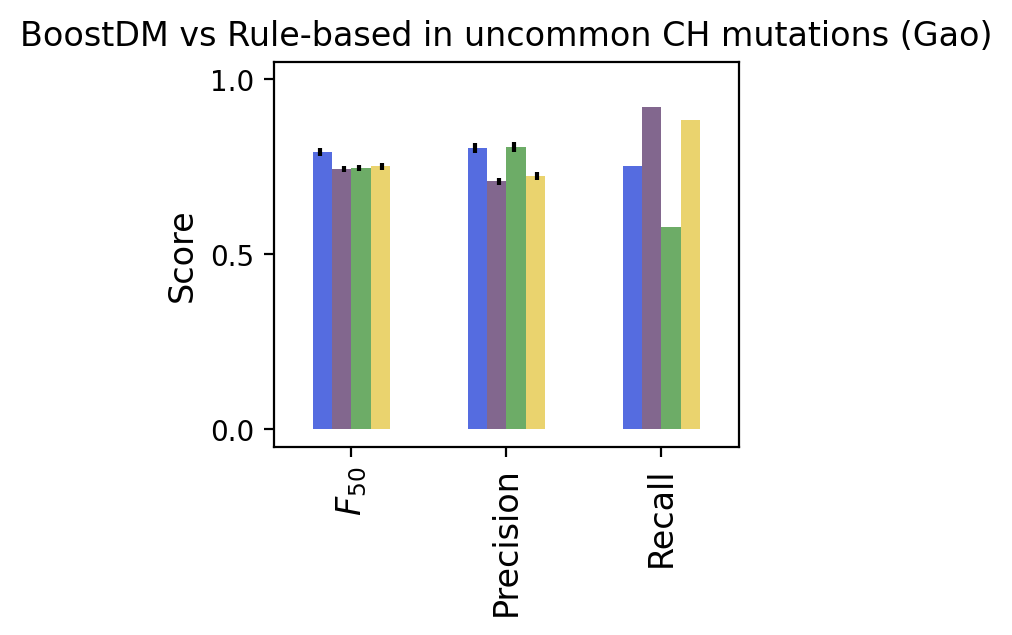

In [94]:
reduced_results.plot.bar(x='Statistic', figsize=(3,2.5), color=['#556CE0', '#82678E', '#6DAC67', '#EAD36E'])

#Add error bar BoostDM
data_Q = error_data[['Statistic', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.BoostDM_median-row.BoostDM_q1], [row.BoostDM_q3-row.BoostDM_median]]
    plt.errorbar(idx-0.2,row.BoostDM_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Niroula
data_Q = error_data[['Statistic', 'Niroula_median', 'Niroula_q1', 'Niroula_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Niroula_median-row.Niroula_q1], [row.Niroula_q3-row.Niroula_median]]
    plt.errorbar(idx-0.05,row.Niroula_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar Bick
data_Q = error_data[['Statistic', 'Bick_median', 'Bick_q1', 'Bick_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Bick_median-row.Bick_q1], [row.Bick_q3-row.Bick_median]]
    plt.errorbar(idx+0.05,row.Bick_median, yerr=ci, fmt=' ', ecolor = 'k')

#Add error bar WHO
data_Q = error_data[['Statistic', 'WHO_median', 'WHO_q1', 'WHO_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.WHO_median-row.WHO_q1], [row.WHO_q3-row.WHO_median]]
    plt.errorbar(idx+0.2,row.WHO_median, yerr=ci, fmt=' ', ecolor = 'k')
    
plt.title('BoostDM vs Rule-based in uncommon CH mutations (Gao)', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
plt.show()

In [ ]:
# SAVE
error_data.to_csv('Gao_exclusive_crossvalidation.csv', sep='\t', index=False)

# 5. Evaluation BoostDM vs Expert curated rules - gene by gene

In [95]:
eval_boostdm = []
eval_niroula = []
eval_bick = []
eval_who = []

for i in range(50):
    ## Set seed random
    seed = 1234 + i
    
    ## Create negative set
    # Empty df
    negative_set = MSKCC_negative_unq[MSKCC_negative_unq['Alt']=='XXXXX']
    # Get negative set with gene frequency equal to positive set
    for gene in genes:
        MSKCC_negative_gene = MSKCC_negative_unq[MSKCC_negative_unq['Gene']==gene]
        negative_set = pd.concat([negative_set,
                                  MSKCC_negative_gene.sample(gene_frec_pos[gene], random_state=seed)])
    negative_set = negative_set.reset_index(drop=True)
    
    ## Create validation set
    validation_set = pd.concat([Gao_Excl_posit_unq[Gao_Excl_posit_unq['Gene'].isin(genes)], negative_set]).reset_index(drop=True)

    ## Merge with BoostDM & Harvard predictions
    validation_set_predictions = pd.merge(validation_set, boostDM_harvard, how='left',
                                          left_on=[ 'Gene','Chrom', 'pos_hg38', 'Alt'],
                                          right_on=['gene','chr', 'pos', 'alt'])
    
    ## Calculate all statistics for each gene and method
    for gene in genes:
        validation_set_gene = validation_set_predictions[validation_set_predictions['Gene']==gene]
        for method in ['boostDM_class', 'Niroula', 'Bick', 'WHO']:
            statistics = []
            for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']:    
                # Calculate statistic
                statistics.append(quality_statistic(validation_set_gene, method=method, statistic=statistic))
            if method == 'boostDM_class': eval_boostdm.append([gene] + statistics)
            elif method == 'Niroula': eval_niroula.append([gene] + statistics)
            elif method == 'Bick': eval_bick.append([gene] + statistics)
            elif method == 'WHO': eval_who.append([gene] + statistics)

In [97]:
Stt = 'Fscore50'
results_gene = []
for gene in genes:
    gene_info = [gene]
    for method in [eval_boostdm, eval_niroula, eval_bick, eval_who]: 
        results = pd.DataFrame(method, columns=['Gene','Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV'])
        Stt_list = results[results['Gene']==gene][Stt]
        gene_info.append(Stt_list.median())
        gene_info.append(pd.DataFrame(Stt_list.tolist()).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0][0])
        gene_info.append(pd.DataFrame(Stt_list.tolist()).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0][0])
    results_gene.append(gene_info)

results_dataframe = pd.DataFrame(results_gene)
results_dataframe.columns = ['Gene', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3',
                                 'Niroula_median', 'Niroula_q1', 'Niroula_q3',
                                 'Bick_median', 'Bick_q1', 'Bick_q3',
                                 'WHO_median', 'WHO_q1', 'WHO_q3']
results_dataframe

,Gene,BoostDM_median,BoostDM_q1,BoostDM_q3,Niroula_median,Niroula_q1,Niroula_q3,Bick_median,Bick_q1,Bick_q3,WHO_median,WHO_q1,WHO_q3
0,DNMT3A,0.736386,0.725610,0.750319,0.723214,0.713028,0.733696,0.602273,0.588924,0.613426,0.698877,0.692379,0.710878
1,TET2,0.854197,0.839363,0.874811,0.811554,0.798376,0.820584,0.811554,0.798376,0.820584,0.811554,0.798376,0.820584
2,TP53,0.742857,0.726257,0.778443,0.619597,0.598886,0.634218,0.754717,0.718563,0.774194,0.724947,0.701466,0.752896
3,ASXL1,0.896226,0.863636,0.931373,0.882353,0.882353,0.918367,0.882353,0.882353,0.918367,0.882353,0.882353,0.918367
4,SF3B1,0.696594,0.657895,0.735294,0.740741,0.702427,0.800000,0.666667,0.666667,0.666667,0.675676,0.649688,0.714286
5,PPM1D,0.909091,0.909091,0.909091,0.909091,0.909091,0.909091,0.961538,0.961538,0.961538,0.961538,0.961538,0.961538


In [98]:
columns = ['Gene']+[x for x in results_dataframe.columns.tolist() if x.endswith('_median')]
reduced_results = results_dataframe.loc[:,columns].reset_index(drop=True)
reduced_results

,Gene,BoostDM_median,Niroula_median,Bick_median,WHO_median
0,DNMT3A,0.736386,0.723214,0.602273,0.698877
1,TET2,0.854197,0.811554,0.811554,0.811554
2,TP53,0.742857,0.619597,0.754717,0.724947
3,ASXL1,0.896226,0.882353,0.882353,0.882353
4,SF3B1,0.696594,0.740741,0.666667,0.675676
5,PPM1D,0.909091,0.909091,0.961538,0.961538


In [99]:
Fbeta_10 = reduced_results.set_index(reduced_results.iloc[:, 0].name)
df = Fbeta_10.stack().reset_index()
print(len(df))
df.columns = ['Gene','Method','Accuracy']
df = df[df['Accuracy'].notna()]
df

24


,Gene,Method,Accuracy
0,DNMT3A,BoostDM_median,0.736386
1,DNMT3A,Niroula_median,0.723214
2,DNMT3A,Bick_median,0.602273
3,DNMT3A,WHO_median,0.698877
4,TET2,BoostDM_median,0.854197
5,TET2,Niroula_median,0.811554
6,TET2,Bick_median,0.811554
7,TET2,WHO_median,0.811554
8,TP53,BoostDM_median,0.742857
9,TP53,Niroula_median,0.619597


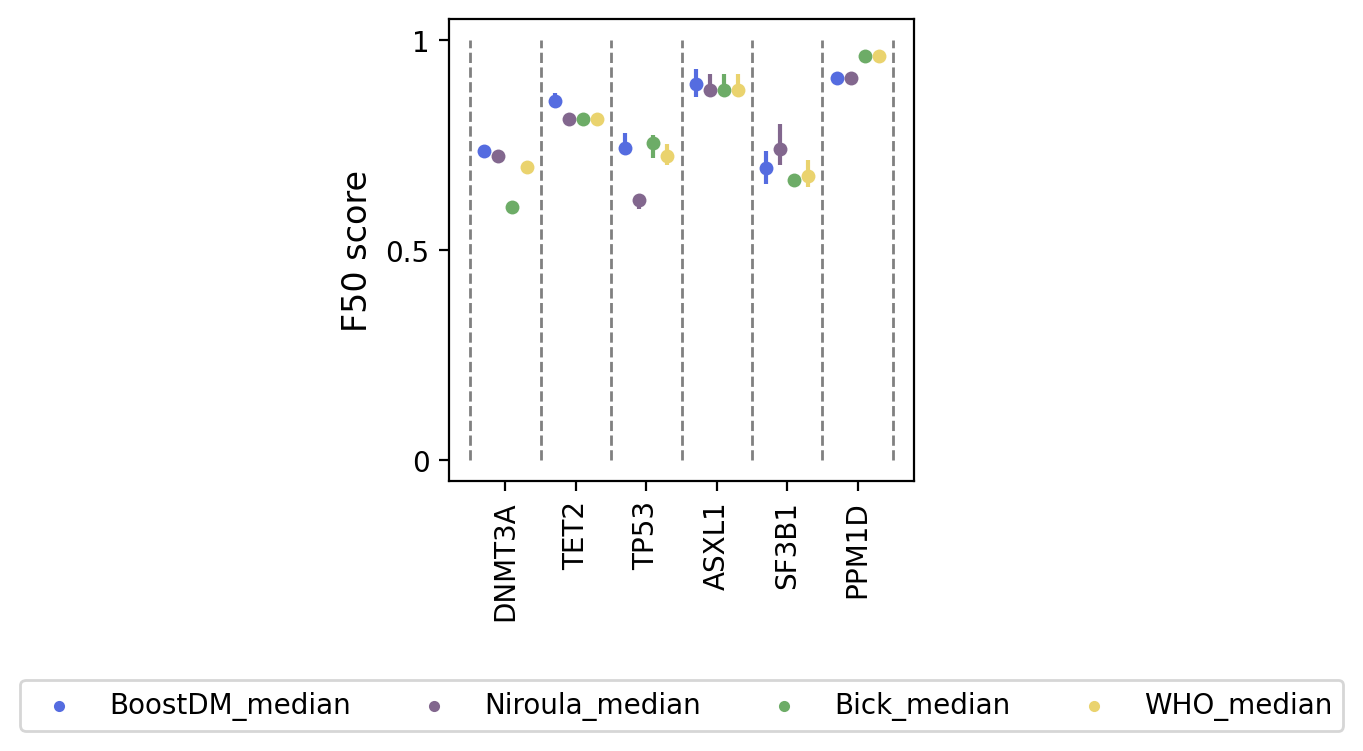

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame containing the data

fig, ax = plt.subplots(figsize=(3, 3))
colors = {'BoostDM': '#556CE0', 'Niroula': '#82678E', 'Bick': '#6DAC67', 'WHO': '#EAD36E'}

sns.stripplot(data=df, x="Gene", y="Accuracy", hue="Method", dodge=True,
              palette=['#556CE0', '#82678E', '#6DAC67', '#EAD36E'])

ax.set_ylabel('F50 score', fontsize=12)
ax.tick_params(axis='x', labelrotation=90, labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '0.5', '1'])
ax.set_xlabel('')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.4), ncol=4, markerscale=0.5)


for x in range(-1, len(df['Gene'].unique())):
    plt.plot([x + 0.5, x + 0.5], [0, df['Gene'].max()], c='grey', linestyle='dashed', linewidth=1)

#Add error bar BoostDM
data_Q = results_dataframe[['Gene', 'BoostDM_median', 'BoostDM_q1', 'BoostDM_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.BoostDM_median-row.BoostDM_q1], [row.BoostDM_q3-row.BoostDM_median]]
    plt.errorbar(idx-0.3,row.BoostDM_median, yerr=ci, fmt=' ', ecolor = colors['BoostDM'])

#Add error bar Niroula
data_Q = results_dataframe[['Gene', 'Niroula_median', 'Niroula_q1', 'Niroula_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Niroula_median-row.Niroula_q1], [row.Niroula_q3-row.Niroula_median]]
    plt.errorbar(idx-0.1,row.Niroula_median, yerr=ci, fmt=' ', ecolor = colors['Niroula'])

#Add error bar Bick
data_Q = results_dataframe[['Gene', 'Bick_median', 'Bick_q1', 'Bick_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.Bick_median-row.Bick_q1], [row.Bick_q3-row.Bick_median]]
    plt.errorbar(idx+0.1,row.Bick_median, yerr=ci, fmt=' ', ecolor = colors['Bick'])

#Add error bar WHO
data_Q = results_dataframe[['Gene', 'WHO_median', 'WHO_q1', 'WHO_q3']]
for idx, row in data_Q.iloc[::-1].iterrows():
    ci = [[row.WHO_median-row.WHO_q1], [row.WHO_q3-row.WHO_median]]
    plt.errorbar(idx+0.3,row.WHO_median, yerr=ci, fmt=' ', ecolor = colors['WHO'])

plt.show()